In [1]:
import mujoco
import mediapy as media
import numpy as np
import time

In [2]:
xml = """
<mujoco model="fixed_sphere_with_moving_body">
    <compiler angle="degree" coordinate="local"/>
    <option timestep="0.01" gravity="0 0 -9.81"/>
    
    <worldbody>
        <!-- Fixed sphere -->
        <body name="fixed_sphere" pos="0 0 0">
            <geom type="sphere" size="1" rgba="0.5 0.5 0.5 0.3" contype="0" conaffinity="0"/>
        </body>
        
        <!-- Moving body -->
        <body name="moving_body" pos="0 0 -1">
            <joint name="ball_joint" type="ball" pos="0 0 1" limited="true" range="0 90"/>
            <geom type="sphere" size="0.1" rgba="1 0 0 1"/>
        </body>
    </worldbody>
    
    <actuator>
        <motor joint="ball_joint" ctrlrange="-1 1" ctrllimited="true"/>
    </actuator>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Simulation parameters
duration = 1 # simulation duration in seconds
time_step = model.opt.timestep
num_steps = int(duration / time_step)

# Initial force to apply
force_magnitude = 10.0

# Create a window to visualize the simulation
renderer = mujoco.Renderer(model)

camera = mujoco.MjvCamera()
camera.lookat = np.array([0, 0, 0])
camera.distance = 1
camera.elevation = -90
camera.azimuth = 90


# Get the index of the moving body
moving_body_id = model.body('moving_body').id

positions = []
frames = []

for step in range(num_steps):
    
    if step % 2 == 0:  # Apply force every 100 timesteps
        dir = np.random.uniform(-1,1,3)
        dir /= np.linalg.norm(dir)
        dir *= 5

        force = force_magnitude * dir
        data.xfrc_applied[moving_body_id, :3] = force  # Apply force in the x, y, z direction
        print(f"Applied force {force} at timestep {step}")

    # Step the simulation
    mujoco.mj_step(model, data)

    # Extract the position of the moving body
    moving_body_position = data.xpos[moving_body_id]

    # if moving_body_position[2] > 0:
    #     moving_body_position[2] = 0
    #     data.qpos[moving_body_id*3+2] = 0

    positions.append(moving_body_position.copy())
    print(f"Timestep {step}: Position of moving body: {moving_body_position}")

    # Render the scene
    renderer.update_scene(data)
    frame = renderer.render()
    frames.append(frame)

    
    #media.show_image(renderer.render())

    # Clear the applied force after application
    data.xfrc_applied[moving_body_id, :3] = 0

    # Slow down the simulation for visualization
    time.sleep(time_step)

media.show_video(frames, fps=60)

# Close the renderer
renderer.close()

# Verify that positions are on the surface of the sphere
for pos in positions:
    distance_from_origin = np.linalg.norm(pos)
    assert np.isclose(distance_from_origin, 1.0, atol=1e-2), f"Body not on sphere surface: {pos}"
    print(f"Verified position on sphere: {pos}")

# with mujoco.Renderer(model) as renderer:
#   mujoco.mj_forward(model, data)
#   renderer.update_scene(data)


#   media.show_image(renderer.render())

Applied force [47.9930446  -0.62577631 14.00985633] at timestep 0
Timestep 0: Position of moving body: [ 0.  0. -1.]
Timestep 1: Position of moving body: [ 1.14118456e-03 -1.48797865e-05 -9.99999349e-01]
Applied force [-45.53320284  20.65553983   0.27588644] at timestep 2
Timestep 2: Position of moving body: [ 2.28125259e-03 -2.97450148e-05 -9.99997397e-01]
Timestep 3: Position of moving body: [ 2.33641639e-03  4.46568642e-04 -9.99997171e-01]
Applied force [27.55403161 40.57588073 -9.71458929] at timestep 4
Timestep 4: Position of moving body: [ 2.38929678e-03  9.22445860e-04 -9.99996720e-01]
Timestep 5: Position of moving body: [ 0.00309446  0.00236202 -0.99999242]
Applied force [ 43.18092872 -22.22657415  11.89061799] at timestep 6
Timestep 6: Position of moving body: [ 0.0037966   0.00379929 -0.99998558]
Timestep 7: Position of moving body: [ 0.00552284  0.00470539 -0.99997368]
Applied force [-47.74771432  -9.70898646  11.22013186] at timestep 8
Timestep 8: Position of moving body: 

Verified position on sphere: [ 0.  0. -1.]
Verified position on sphere: [ 1.14118456e-03 -1.48797865e-05 -9.99999349e-01]
Verified position on sphere: [ 2.28125259e-03 -2.97450148e-05 -9.99997397e-01]
Verified position on sphere: [ 2.33641639e-03  4.46568642e-04 -9.99997171e-01]
Verified position on sphere: [ 2.38929678e-03  9.22445860e-04 -9.99996720e-01]
Verified position on sphere: [ 0.00309446  0.00236202 -0.99999242]
Verified position on sphere: [ 0.0037966   0.00379929 -0.99998558]
Verified position on sphere: [ 0.00552284  0.00470539 -0.99997368]
Verified position on sphere: [ 0.00724367  0.00560687 -0.99995805]
Verified position on sphere: [ 0.00782405  0.00627355 -0.99994971]
Verified position on sphere: [ 0.00839678  0.0069341  -0.9999407 ]
Verified position on sphere: [ 0.00928243  0.00646637 -0.99993601]
Verified position on sphere: [ 0.010159    0.00599232 -0.99993044]
Verified position on sphere: [ 0.01041127  0.00485601 -0.99993401]
Verified position on sphere: [ 0.01065

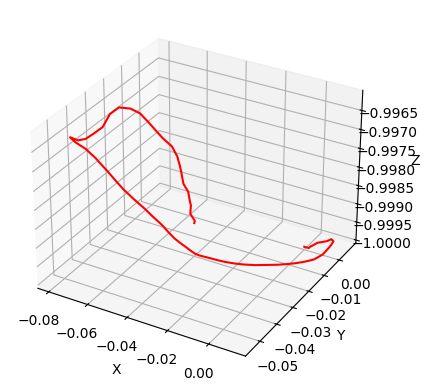

In [3]:
import matplotlib.pyplot as plt

positions = np.array(positions)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'r-')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()